In [33]:
from pathlib import Path
import xarray as xr
import pandas as pd


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import palettable

In [34]:
def get_duration_and_size(lab, rettype='df'):
    """Returns either a Pandas DataFrame (default) or dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    # put eventID as key, values are dict: {duration: D, size: [s_0, ..., s_d]}
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev]['duration'] += 1 # continuing
                    dur[ev]['size'].append(np.count_nonzero(tmp==ev))
                else:
                    dur[ev] = dict() # new event
                    dur[ev]['duration'] = 1
                    dur[ev]['size'] = [np.count_nonzero(tmp==ev)]
    if rettype == 'df':
        # convert to dataFrame
        df = pd.DataFrame.from_dict(dur, orient ='index')
        # compute average size and include as a column
        asiz = []
        msiz = []
        for s in df['size']:
            asiz.append(np.mean(s))
            msiz.append(np.max(s))
        df['AvgSiz'] = asiz
        df['MaxSiz'] = msiz
        # get distribution of average size
        return df
    else:
        return dur  # AvgSiz and MaxSiz not included in output dict.

In [ ]:
dloc = Path("/Volumes/Glyph6TB/CMIP6")
ds = xr.open_dataset(dloc / "pr_events_CESM2_aqua-control_r1i1p1f1.nc")

In [3]:
prev = ds['precip_events']

In [35]:
dursiz = get_duration_and_size(prev)

In [9]:
prevbin = np.where(prev > 0, 1, 0)

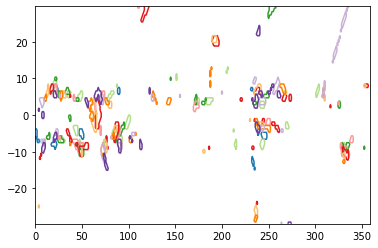

In [32]:
lons, lats = np.meshgrid(ds['lon'], ds['lat'])
fig, ax = plt.subplots()

for t in range(10):
    ax.contour(lons, lats, prevbin[t,:,:], levels=[.5], colors=[c[t]])


In [25]:
c = palettable.colorbrewer.qualitative.Paired_12.mpl_colors

In [30]:
list(c[0])

[0.6509803921568628, 0.807843137254902, 0.8901960784313725]

In [40]:
dursiz['duration'].mean() + 3*(dursiz['duration'].std())

7.517014617379841

In [42]:
dursiz['duration'].where(dursiz['duration'] >= 7.5).dropna()

397      10.0
466      10.0
481       9.0
629       9.0
777       8.0
         ... 
30030    13.0
30118    22.0
30156    17.0
30179    10.0
30203     9.0
Name: duration, Length: 485, dtype: float64

In [109]:
event_id = 30030
evselect = np.where(prev.values == event_id, 1, 0)  # mask for a single event
event_nds = np.argwhere(prev.values == event_id)  # list of points in event (t, lat, lon)
event_time = [x[0] for x in event_nds]  # the time indices of event

# event_subset = evselect[np.unique(event_time), :, :]
# event_subset.shape

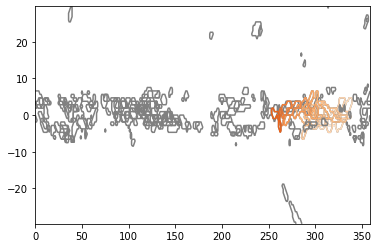

In [110]:
fig, ax = plt.subplots()
c = palettable.colorbrewer.sequential.Oranges_3.mpl_colormap
ntimes = len(np.unique(event_time))
for i, t in enumerate(np.unique(event_time)):
    ax.contour(lons, lats, prevbin[t,:,:], levels=[.5], colors='gray')
    ax.contour(lons, lats, evselect[t,:,:], levels=[.5], colors=[c(i/ntimes)])



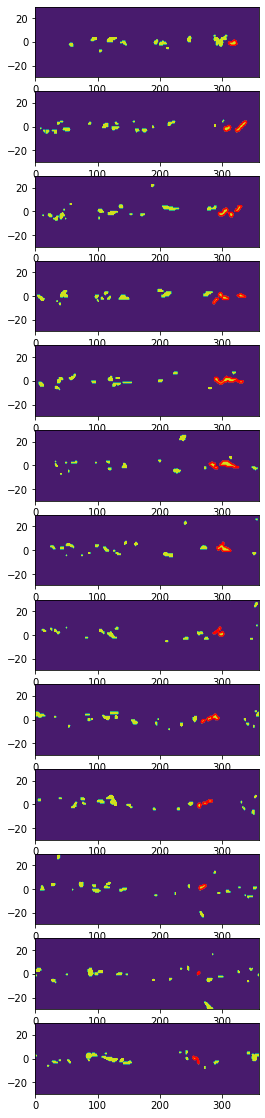

In [111]:
fig, ax = plt.subplots(figsize=(4, 20), nrows=ntimes)
for i, t in enumerate(np.unique(event_time)):
    ax[i].contourf(lons, lats, prevbin[t,:,:])
    ax[i].contour(lons, lats, evselect[t,:,:], levels=[.5], colors='red')



In [85]:
event_nds[0]

array([ 47,  28, 106])

In [94]:
c = palettable.colorbrewer.qualitative.Paired_12.mpl_colormap

In [95]:
c

In [96]:
c?

Signature:      c(X, alpha=None, bytes=False)
Type:           LinearSegmentedColormap
String form:    <matplotlib.colors.LinearSegmentedColormap object at 0x7fac0970b6a0>
File:           ~/miniconda3/envs/py38/lib/python3.8/site-packages/matplotlib/colors.py
Docstring:     
Colormap objects based on lookup tables using linear segments.

The lookup table is generated using linear interpolation for each
primary color, with the 0-1 domain divided into any number of
segments.
Init docstring:
Create color map from linear mapping segments

segmentdata argument is a dictionary with a red, green and blue
entries. Each entry should be a list of *x*, *y0*, *y1* tuples,
forming rows in a table. Entries for alpha are optional.

Example: suppose you want red to increase from 0 to 1 over
the bottom half, green to do the same over the middle half,
and blue over the top half.  Then you would use::

    cdict = {'red':   [(0.0,  0.0, 0.0),
                       (0.5,  1.0, 1.0),
                      